#  A Bayesian Exact Test

Here we (re)-develop a Bayesian approach to Fisher's exact test following the example from Andrew Gelman's [blog post](https://andrewgelman.com/2009/10/13/what_is_the_bay/) and compare it to the latter.

We use Fisher's *Lady tasting tea* data that consists of the number of times said lady guessed whether tea or milk was *first* added to a cup of tea. Fisher porposed to serve eight cups of tea, 4 of each variety, in random order. For our simulation the lady was able to correctly identify the first ingredient 3 times each, giving us a $2 \times 2$ contingency table.

Thus our data set looks like this:

In [70]:
y_tea <- 3
y_milk <- 1
n_tea <- n_milk <- 4

tea_data <- matrix(
    c(y_tea, y_milk, n_tea - y_tea, n_milk - y_milk), ncol = 2,
    dimnames = list("guess" = c("tea", "milk"),
                    "given" = c("tea", "milk"))
    
)
print(tea_data)

      given
guess  tea milk
  tea    3    1
  milk   1    3


We test whether *given* and *guess* are independent of each other, i.e. a null hypothesis of no association against an alternative that we have a positive association.

In [73]:
fisher.test(tea_data, alternative = "greater")


	Fisher's Exact Test for Count Data

data:  tea_data
p-value = 0.2429
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.3135693       Inf
sample estimates:
odds ratio 
  6.408309 


For a significance level of $\alpha = 0.10$ we wouldnt reject the null here. Let's compare this to a Bayesian approach using `greta`. According to Gelman we would assume a Binomial likelihood for both the number of *tea guessed - tea given* and *milk guessed - tea given*. The conjugate prior for this is the Beta for which we will use Jeffreys prior. This can be done analytically, but we will in addition use a sampler for demonstration.

In [84]:
library(greta)
suppressPackageStartupMessages(library(tidyverse))

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

We use priors with hyperparameters $a=b=0.5$ and set up the respective models.

In [75]:
theta_tea <- greta::beta(.5, .5)
theta_milk <- greta::beta(.5, .5)

distribution(y_tea) <- greta::binomial(n_tea, theta_tea)
distribution(y_milk) <- greta::binomial(n_milk, theta_milk)

Then we sample from the model.

In [76]:
m <- greta::model(theta_tea, theta_milk)
samples <- as.matrix(greta::mcmc(m))

    warmup ====================================   100/100 | eta:  0s          
  sampling ==================================== 1000/1000 | eta:  0s          


If the lady is indeed able to reliably guess the tea, we would assume that the difference of posterior samples primarily positive.

In [81]:
theta_1_samples <- samples[ ,1]
theta_2_samples <- samples[ ,2]

In [104]:
thetas <- data.frame(Theta=theta_1_samples - theta_2_samples)

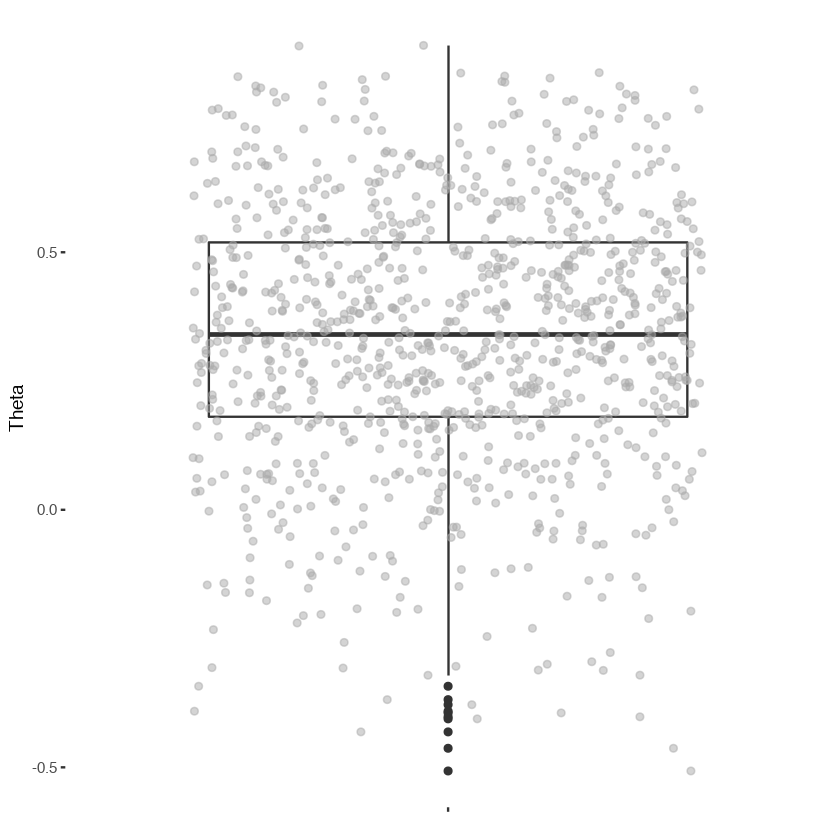

In [105]:
thetas%>%
    ggplot() +
    geom_boxplot(aes(x="", y=Theta)) +
    geom_jitter(aes(x="", y=Theta), col="darkgrey", alpha=0.5) +
    xlab(NULL) +
    ggthemes::theme_tufte()

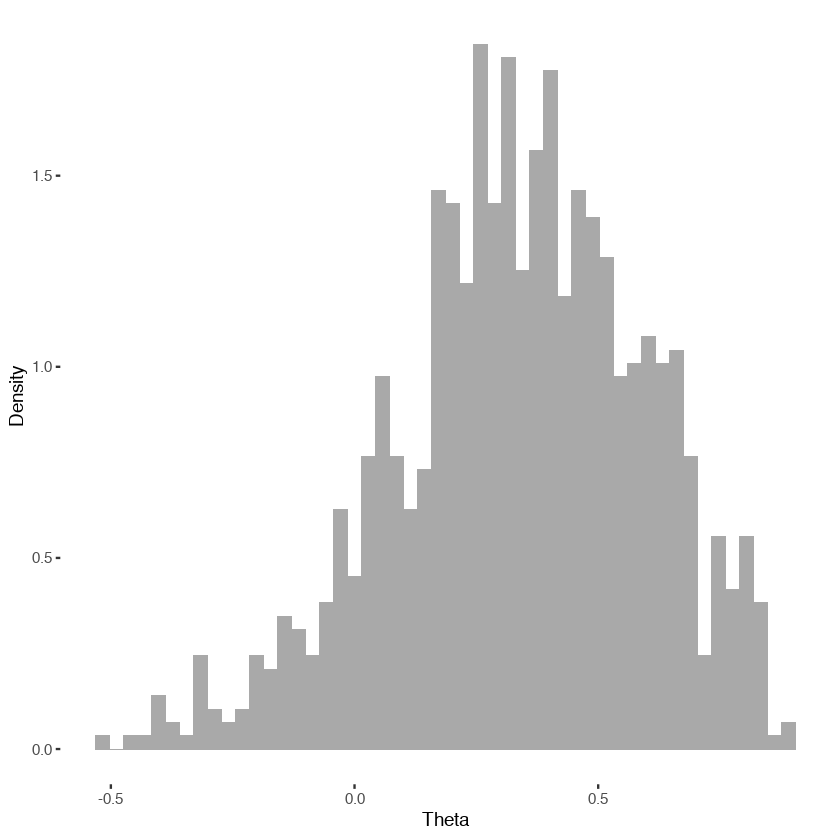

In [112]:
thetas%>%
    ggplot() +
    geom_histogram(aes(x=Theta, y=..density..), bins=50, fill="darkgrey") +
    scale_y_continuous("Density") +
    ggthemes::theme_tufte()

In order to compute the probability $P[\theta_{Tea} > \theta_{Milk}]$ we we use a Monte Carlo approximator.

The following is the probability that there is a 90% change that the lady could tell the difference.

In [113]:
mean(thetas$Theta > 0)

[1] 0.902